In [1]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import load_model, Sequential, Model

# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
    import tensorflow.compat.v2 as tf
    tf.enable_v2_behavior()
    assert tf2.enabled()

np.random.seed(12211)  

%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_funcs
import help_train # Wait, when did we start doing this instead of the line profiler?

In [2]:
train_mode = True # False if you don't want to train again

In [3]:
num_train = 200000 # 10000, 4000 # Max: 200000 
num_test = 20000 # 1000 # Max: 20000

In [4]:
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][6] # Soon there will be more!
# Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][3]
Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew', 'OBSuq'][7] # Test on the same things we tested before (SDSS)
surveystring = ['SDSS', 'VIPERS', 'DEEP2', 'PRIMUS']

In [5]:
# Hyperparameters
prtb = True
n_epochs = 5 # 100
if prtb:
    D = 4 #6  # number of features (in input space)
    K = 3 #16 # number of mixture components # a "component" of a GMM is one gaussian, right?
else:
    D = 5
    K = 3
    
learning_rate = 1e-4
decay_rate= 1e-2
batch_size = 256

# Here we define hyperparameters!
save_mod = 'saved_hubs/tf2models/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [6]:
X_train, y_train, _, _ = help_train.loadTrainTest_july(dirIn = '/data/a/cpac/nramachandra/Projects/phoZ/Data/fromGalaxev/photozs/datasets/data_july_2020/')
X_test, y_test, X_err, label_test = help_train.loadTest(Testset, dirIn = '/data/a/cpac/aurora/MDN_phoZ/Data/fromGalaxev/photozs/datasets/data_feb_2021/') # data_feb_2021

----------
number of datapoints:  187462
z-minmax:  0.0020016062 1.249997
ColMag-min:  [-0.091 -0.053 -0.025 -0.105 12.   ]
ColMag-max:  [ 3.825  2.83   1.694  1.502 23.5  ]
----------
----------
number of datapoints:  10322
z-minmax:  0.0020014732 1.249283
ColMag-min:  [-4.168e-02 -7.187e-03  5.620e-02 -6.465e-02  1.200e+01]
ColMag-max:  [ 3.619  2.799  1.61   1.44  23.498]
----------
----------
number of datapoints:  4339
z-minmax:  7.926745e-06 7.01
ColMag-min:  [ -5.188  -3.89   -2.103 -15.923  12.115]
ColMag-max:  [17.029  7.926  4.182  2.265 25.71 ]
----------


In [7]:
X_train, y_train, X_trainShuffleOrder = help_train.shuffle(X_train, y_train) # literally just shuffle the data
# X_test, y_test, label_test, X_testShuffleOrder = shuffleOBS(X_test, y_test, test_labels) # Why aren't we doing this?

In [8]:
min_col = [-0.09145837, -0.05327791, -0.02479261, -0.10519464] #-0.03 #-5 # Same as what we got from print_limits
max_col = [ 3.825315,   2.8303378,  1.6937237,  1.5019817] #3.4 #5
min_mag = 12
max_mag = 23
min_z = 0.0 #np.min(y_train)
max_z = 1.1 #np.max(y_train)

mins_and_maxs = [min_col, max_col, min_mag, max_mag, min_z, max_z]

X_test, y_test, label_test, mask_cond, X_err = help_train.minmax_cutsOBSarr(X_test, X_err, y_test, label_test, mins_and_maxs) # Make sure all our data falls within the desired range (and bins)

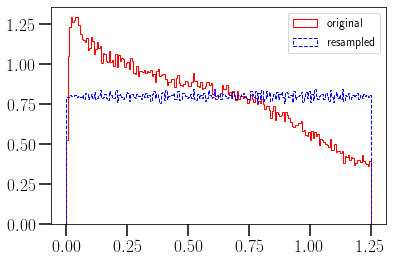

(79600,)


In [9]:
# Notice, this cell is recursive. (If you run it multiple times, the resulting plot will change)
resampleTrain = True
n_bins = 200 
select_per_bin = 400 # 500, 50

if resampleTrain:
    X_train, y_train, resampled_ind = help_train.resample(X_train, y_train, n_bins, select_per_bin) # What is "rest"? And where did the original data go?

In [10]:
print("Size of features in training data: {}".format(X_train.shape)) # what do we mean features?
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (79600, 5)
Size of output in training data: (79600,)
Size of features in test data: (2767, 5)
Size of output in test data: (2767,)


In [11]:
# Previously, we said "this notebook doesn't train models, it deploys them"
# Now, we are training models (I think?)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle

# This preproc stuff is related to "scaling routine" -- right? Yes :)
preproc = Pipeline([('stdscaler', StandardScaler())]) # This preproc tool is what allows us to transform inputs into min-max space (and therefore to feed it to the trained model)
# preproc = Pipeline([('stdscaler', MinMaxScaler())])
X_train = preproc.fit_transform(X_train) # Not sure how "fit_transform" is different from the original "transform"?

scalerfile = save_mod + '_scaling_X'
pickle.dump(preproc, open(scalerfile, 'wb'))
preproc = pickle.load(open(scalerfile, 'rb'))

X_test = preproc.transform(X_test) # This transformation puts our input into min-max space

# preproc_y = Pipeline([('stdscaler', StandardScaler())])
preproc_y = Pipeline([('stdscaler', MinMaxScaler())])

y_train = preproc_y.fit_transform(y_train.reshape(-1, 1))

scalerfile = save_mod + '_scaling_y'
pickle.dump(preproc_y, open(scalerfile, 'wb'))
preproc_y = pickle.load(open(scalerfile, 'rb'))

y_test = preproc_y.transform(y_test.reshape(-1, 1))

In [12]:
help_train.print_limits(X_train, y_train)

help_train.print_limits(X_test, y_test)

----------
number of datapoints:  79600
z-minmax:  0.0 1.0000001
ColMag-min:  [-1.651 -2.279 -2.335 -2.295 -4.242]
ColMag-max:  [4.724 4.212 3.53  3.873 1.268]
----------
----------
number of datapoints:  2767
z-minmax:  -0.0015975338 0.8793446
ColMag-min:  [-1.639 -2.235 -2.322 -2.304 -4.188]
ColMag-max:  [4.746 4.15  3.615 3.919 1.028]
----------


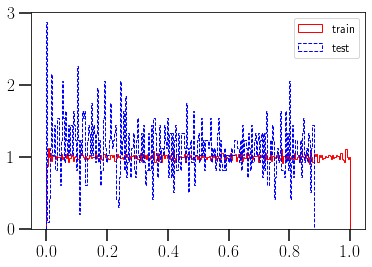

In [13]:
# That is a very messy histogram :P Looks like the precision on test is much lower than on train?
plt.figure(23)

plt.hist(y_train, density=True, bins = 250, histtype='step', label='train')
plt.hist(y_test, density=True, bins = 250, histtype='step', label='test')
plt.legend()
plt.savefig("precision" + str(num_train) + ".png")

In [14]:
def decay(epoch):
    if (epoch < 1):
        return learning_rate
    else:
        return learning_rate*(1.0/(1.0+decay_rate*(epoch)))

In [15]:
class PrintLR(tf.keras.callbacks.Callback): # Print learning rate at every epoch
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model_train.optimizer.lr.numpy()))

In [16]:
#from help_train import decay as decay
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [17]:
# These are the network parameters!! (This whole cell is network architecture)

# x = tf.keras.layers.InputLayer(input_shape=(D,)),
non_lin_act = tf.nn.relu #tf.nn.tanh
y_true = tf.keras.Input(shape=(1,))
inputs = tf.keras.Input(shape=(D,))
layer_1 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(inputs)
layer_1a = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1)
layer_1b = tf.keras.layers.Dense(units=2048, activation=non_lin_act)(layer_1a)
layer_1c = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1b)
layer_2 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(layer_1c)
layer_3 = tf.keras.layers.Dense(units=256, activation=non_lin_act)(layer_2)
layer_4 = tf.keras.layers.Dense(units=128, activation=non_lin_act)(layer_3)
layer_5 = tf.keras.layers.Dense(units=64, activation=non_lin_act)(layer_4)
layer_6 = tf.keras.layers.Dense(units=32, activation=non_lin_act)(layer_5)
mu = tf.keras.layers.Dense(units=K, activation=None, name="mu")(layer_6)
var = tf.keras.backend.exp(tf.keras.layers.Dense(units=K, activation=tf.nn.softplus, name="sigma")(layer_6))
pi = tf.keras.layers.Dense(units=K, activation=tf.nn.softmax, name="mixing")(layer_6)

In [18]:
model_train = Model([inputs, y_true], [mu, var, pi], name='mdn') # Previously, this was the mixed density model (is that the same as a Gaussian mixture model?)

In [19]:
# Define custom loss
def custom_loss(layer):
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true, mu, var, pi):
        mixture_distribution = tfp.distributions.Categorical(probs=pi)
        distribution = tfp.distributions.Normal(loc=mu, scale=var)
        likelihood = tfp.distributions.MixtureSameFamily(mixture_distribution=mixture_distribution,components_distribution=distribution)

        log_likelihood = -1.0*likelihood.log_prob(tf.transpose(y_true)) # A little confusing (talk later)
        mean_loss = tf.reduce_mean(log_likelihood)

        return mean_loss
    return loss
    
model_train.add_loss(custom_loss(inputs)(y_true, mu, var, pi))
model_train.compile(optimizer='Nadam')
model_train.summary()

Model: "mdn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          2560        input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         525312      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2048)         2099200     dense_1[0][0]                    
________________________________________________________________________________________________

In [20]:
learning_rate

0.0001

### Perturb or remove bands

In [29]:
if prtb:
    band_n = 0 # remove the u band
    approach = 'e'
    prtb_X_train = help_funcs.perturb(X_train, band_n, approach = approach)
    prtb_X_test = help_funcs.perturb(X_test, band_n, approach = approach)
    prtb_X_err = help_funcs.perturb(X_err, band_n, approach = approach)
    suffix = '_perturbed'
    my_X_train = prtb_X_train
    my_X_test = prtb_X_test
    my_X_err = prtb_X_err
else:
    suffix = ""
    my_X_train = X_train
    my_X_test = X_test
    my_X_err = X_err

### Train!

Epoch 1/5
280/280 [==============================] - 7s 23ms/step - loss: 0.9211 - val_loss: 0.9217

Learning rate for epoch 1 is 9.999999747378752e-05
Epoch 2/5
280/280 [==============================] - 6s 22ms/step - loss: 0.9206 - val_loss: 0.9201

Learning rate for epoch 2 is 9.900989971356466e-05
Epoch 3/5
280/280 [==============================] - 6s 22ms/step - loss: 0.9203 - val_loss: 0.9198

Learning rate for epoch 3 is 9.803921420825645e-05
Epoch 4/5
280/280 [==============================] - 6s 22ms/step - loss: 0.9203 - val_loss: 0.9199

Learning rate for epoch 4 is 9.708738070912659e-05
Epoch 5/5
280/280 [==============================] - 6s 22ms/step - loss: 0.9201 - val_loss: 0.9196

Learning rate for epoch 5 is 9.61538462433964e-05
CPU times: user 21min 23s, sys: 1min 47s, total: 23min 10s
Wall time: 34.6 s


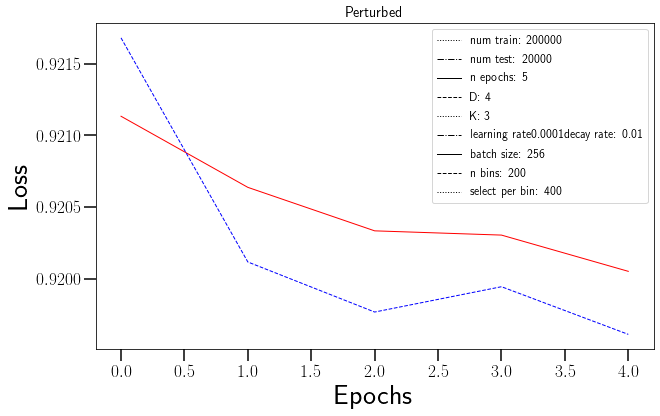

In [30]:
%%time
if train_mode:

    history = model_train.fit([my_X_train, y_train], validation_split = 0.1, epochs=n_epochs, batch_size = batch_size, callbacks=callbacks) # What's this history about?
    # The problem is in the above line
    model_train.save_weights(save_mod + '.h5')
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs', fontsize = 28)
    plt.ylabel('Loss', fontsize = 28)
    
    # Fancy legend
    fake_lines = [plt.plot([], [], c = "black")[0] for i in range(0,10)]
    param_labels = ["num train: " + str(num_train), "num test: " + str(num_test), "n epochs: " + str(n_epochs), "D: " + str(D), "K: " + str(K), "learning rate" + str(learning_rate) + "decay rate: " + str(decay_rate), "batch size: " + str(batch_size), "n bins: " + str(n_bins), "select per bin: " + str(select_per_bin)]
    plt.legend(handles = fake_lines, labels = param_labels, loc = "upper right")
    if prtb:
        plt.title("Perturbed")
    plt.savefig("training_plots/loss_epochs_ntrain" + str(num_train) + "_ntest" + str(num_test) + "_nepochs" + str(n_epochs) + "_D" + str(D) + "_K" + str(K) + "_lr" + str(learning_rate) + "_dr" + str(decay_rate) + "_bs" + str(batch_size) + "_re" + str(resampleTrain) + "_nbins" + str(n_bins) + "_spb" + str(select_per_bin) + suffix + ".png")

In [31]:
model_train.load_weights(save_mod + '.h5') # Previously, this exact line was loading the weights of (from?) the mixed density model

In [39]:
import zeropoints

# Should cover at least the extent of the true redshifts.
zgrid = np.arange(-0.1,0.8,0.01)

# Selection. SDSS galaxies above z>0.01.
sel = (label_test==0)#&(y_test>0.01)

# Value to reduce the likelihood ratio significance.
# Adjust higher for larger samples.
extra_cov = (7.)**2
# Integration steps to marginalize photometric noise.
Nintegral = 10
# Clip galaxies with crazy low likelihoods. Roughly number of sigmas.
cutoff = 5
# Steps of the MCMC.
Nchain = 100

print(my_X_err[sel])
errors = my_X_err[sel].copy()
# Sometimes it's good to add more error. 
# Our models will not be accurate up to S/N~1000
# errors = np.sqrt(errors**2 + 0.02**2)

# Step size of the proposal distribution.
step_size = 0.005

xchain, P = zeropoints.run_zp_chain(
    preproc,
    preproc_y,
    model_train,
    y_test[sel], 
    my_X_test[sel].copy(), 
    errors, 
    Nintegral,
    Nchain,
    method = "exact", # Exact likelihood
    #method = "approximate", # Approximate likelihood.
    params_init = None,
    #params_init = pinit,
    cutoff = cutoff, 
    extra_cov = extra_cov,
    step_size = step_size,
    zgrid = zgrid
)

[[0.019 0.011 0.017 0.007]
 [0.087 0.054 0.08  0.033]
 [0.191 0.088 0.125 0.051]
 ...
 [0.139 0.066 0.082 0.033]
 [0.275 0.083 0.128 0.039]
 [0.167 0.066 0.11  0.041]]


ValueError: operands could not be broadcast together with shapes (1948,4) (3,) 

In [34]:
print(sel.shape)
print(sel)
print(my_X_err.shape)

(2767, 2767)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]
(2767, 4)


In [52]:
# New version
#sel_ind = 0 # pick a survey
#sel = (label_test == sel_ind) # masks the selection index
#xzero_correction = np.loadtxt(save_mod + '_xzero_' + surveystring[sel_ind])

# New perturbed and unperturbed
#prtb_y_pred_mean, prtb_y_pred_std  = help_funcs.prediction_zp(prtb_X_test[sel], xzero_correction, model_train, preproc, preproc_y)
#og_y_pred_mean, og_y_pred_std  = help_funcs.prediction_zp(X_test[sel], xzero_correction, model_train, preproc, preproc_y)

In [29]:
def Nesar_prediction_zp_all(X_test, label_test, save_mod, surveystring, model_train, preproc, preproc_y):
    xzero = np.zeros_like(X_test[:,:4])
    xzero[label_test == 0] = np.loadtxt(save_mod + '_xzero_' + surveystring[0])
    xzero[label_test == 1] = np.loadtxt(save_mod + '_xzero_' + surveystring[1])
    xzero[label_test == 2] = np.loadtxt(save_mod + '_xzero_' + surveystring[2])  
    f_real = X_test.copy()
    f_real[:,:4] = f_real[:,:4] + xzero
    f_real = preproc.transform(f_real)
    y_pred = np.array(model_train(  [f_real, np.zeros(shape = f_real.shape[0]) ] ))
    #y_pred = np.array(model_train(f_real)) # Apparently this won't work anymore? We now need two inputs...
    y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
    y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
    y_pred_std = np.sqrt(np.log(y_pred[1, :, :][:, y_pred_arg][:, 0]))
    # This is exactly the same as what Nesar does in his notebook
    # But, it's randomly not what we will actually use for plotting?? That's `y_pred_mean` and the like, which we aren't calculating here
    y_pred_3means = preproc_y.inverse_transform(y_pred[0, :, :])
    y_pred_3std = preproc_y.inverse_transform( np.sqrt(np.log(y_pred[1, :, :])  ))
    y_pred_3weights = y_pred[2, :, :]
    predstdweights = np.array([y_pred_3means, y_pred_3std, y_pred_3weights])
    return y_pred_3means, y_pred_3std, y_pred_3weights, y_pred_arg, y_pred_mean, y_pred_std, xzero

In [129]:
# y_pred = np.array(model_train(X_test))
y_pred = np.array(model_train(  [my_X_test, np.zeros(shape = prtb_X_test.shape[0]) ] ))

y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
y_pred_std = np.sqrt(np.log(y_pred[1, :, :][:, y_pred_arg][:, 0]))
# This is all the same as prediction_zp, but isn't included in Nesar's version

In [130]:
# These are the same (I think?) as what we calculate in Nesar's version of prediction_zp
y_pred_3means = preproc_y.inverse_transform(y_pred[0, :, :]) # Previously, we used preproc_y to pick the best Gaussian (of the three that make up the Gaussian mixture model)
y_pred_3std = preproc_y.inverse_transform( np.sqrt(np.log(y_pred[1, :, :])  ))
y_pred_3weights = y_pred[2, :, :]

y_test_all = preproc_y.inverse_transform(y_test)

predstdweights = np.array([y_pred_3means, y_pred_3std, y_pred_3weights])
truelabel = np.array([y_test_all[:, 0], label_test])

np.save(save_mod+'test_true', predstdweights )
np.save(save_mod+'test_pred', truelabel )

num_train: 200000


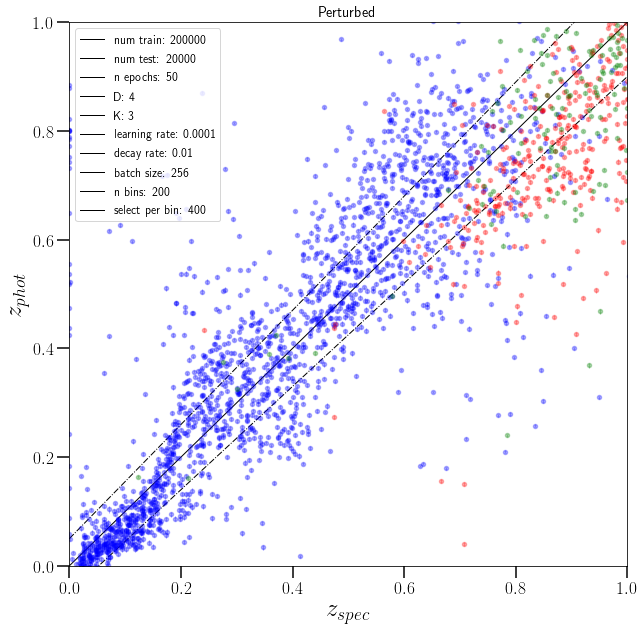

<Figure size 432x288 with 0 Axes>

In [136]:
ifPlotWeighted = True
y_pred_mean_best = y_pred_mean # So I've never understood this part. How do we know it's the best? And if it's always been the best, why didn't we call it the best from the beginning?
y_pred_std_best = y_pred_std   # No good answer ;) 

fig, ax = plt.subplots(figsize=(10, 10,)) # How does this work (or conflict) with plt.figure() down below?
if ifPlotWeighted:

    colorstring = ['b', 'r', 'g', 'k', 'orange']
    surveystring = ['SDSS', 'VIPERS', 'DEEP2']

    plt.figure(22)#, figsize=(10, 10,))

    C = 0.05
    z_t = np.array([0, 1])
    z_tp = z_t + C*(1+z_t)
    z_tm = z_t - C*(1+z_t)

    ax.plot(z_t, z_t, 'k')
    ax.plot(z_t, z_tp, 'k-.')
    ax.plot(z_t, z_tm, 'k-.')

    for label_ind in [0, 1, 2]:
        surveyindx = np.where(label_test == label_ind)
        offset = 0.0
        
        ax.errorbar(preproc_y.inverse_transform(y_test)[surveyindx][:, 0], offset + preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[surveyindx][:, 0], yerr= preproc_y.inverse_transform(y_pred_std_best.reshape(-1, 1))[surveyindx][:, 0], fmt = 'o', marker=None, ms = 4, alpha = 0.3, label = 'Training: Synthetic, Testing: '+surveystring[label_ind], c = colorstring[label_ind])

ax.set_ylabel(r'$z_{phot}$', fontsize=25)
ax.set_xlabel(r'$z_{spec}$', fontsize=25)
        
ax.set_xlim(0.0, 1)
ax.set_ylim(0.0, 1)

plt.tight_layout()
# plt.axes().set_aspect('equal')

#leg1 = ax.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)
fake_lines = [ax.plot([], [], c = "black", linestyle = '-')[0] for i in range(0,10)]
print("num_train: " + str(num_train))
param_labels = ["num train: " + str(num_train), "num test: " + str(num_test), "n epochs: " + str(n_epochs), "D: " + str(D), "K: " + str(K), "learning rate: " + str(learning_rate), "decay rate: " + str(decay_rate), "batch size: " + str(batch_size), "n bins: " + str(n_bins), "select per bin: " + str(select_per_bin)]
ax.legend(handles = fake_lines, labels = param_labels, loc = "upper left")
if prtb:
    ax.set_title("Perturbed")
#ax.add_artist(leg1)
##fig.savefig('phoz_compare_surveys_numtrain_' + str(num_train) + '.pdf', bbox_inches='tight')
fig.savefig("training_plots/phoz_ntrain" + str(num_train) + "_ntest" + str(num_test) + "_nepochs" + str(n_epochs) + "_D" + str(D) + "_K" + str(K) + "_lr" + str(learning_rate) + "_dr" + str(decay_rate) + "_bs" + str(batch_size) + "_re" + str(resampleTrain) + "_nbins" + str(n_bins) + "_spb" + str(select_per_bin) + suffix + ".png")
fig.show()
# num train, num test, n epochs, D, K, learning rate, decay rate, batch size, nbins, select per bin

In [138]:
print(num_test)

20000


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


0
1
2


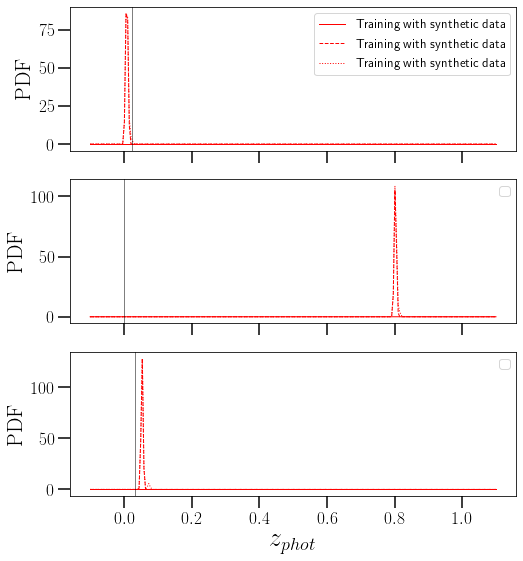

In [144]:
# Plot a pdf
from scipy import stats
#nrows = 3
#fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex = True, figsize=(8, nrows*3), num='pdfs')
fig, axes = help_funcs.plot_pdfs(y_pred_3means, y_pred_3weights, y_pred_3std, y_test_all, num_train = num_train, num_test = num_test, num=nrows, label = 'Training with synthetic data', color = 'red', train=False)
fig.savefig("quick_pdfs.png")